In [78]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.sparse import csr_matrix
from sklearn.decomposition import NMF
import pickle
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

In [79]:
ratings = pd.read_csv("/home/evangelo/Downloads/ml-latest-small/ratings.csv")
movies = pd.read_csv("/home/evangelo/Downloads/ml-latest-small/movies.csv")

In [80]:
ratings.groupby('movieId')['rating'].mean()

movieId
1         3.920930
2         3.431818
3         3.259615
4         2.357143
5         3.071429
            ...   
193581    4.000000
193583    3.500000
193585    3.500000
193587    3.500000
193609    4.000000
Name: rating, Length: 9724, dtype: float64

In [81]:
movies

movieId                                      title  \
0           1                           Toy Story (1995)   
1           2                             Jumanji (1995)   
2           3                    Grumpier Old Men (1995)   
3           4                   Waiting to Exhale (1995)   
4           5         Father of the Bride Part II (1995)   
...       ...                                        ...   
9737   193581  Black Butler: Book of the Atlantic (2017)   
9738   193583               No Game No Life: Zero (2017)   
9739   193585                               Flint (2017)   
9740   193587        Bungo Stray Dogs: Dead Apple (2018)   
9741   193609        Andrew Dice Clay: Dice Rules (1991)   

                                           genres  
0     Adventure|Animation|Children|Comedy|Fantasy  
1                      Adventure|Children|Fantasy  
2                                  Comedy|Romance  
3                            Comedy|Drama|Romance  
4                                          Comedy  
...                                           ...  
9737              Action|Animation|Comedy|Fantasy  
9738                     Animation|Comedy|Fantasy  
9739                                        Drama  
9740                             Action|Animation  
9741                                       Comedy  

[9742 rows x 3 columns]

In [82]:
movies.title.sample(5)

5185                  Divorcee, The (1930)
6570             Hunting Party, The (2007)
7560                          Super (2010)
8719    The Cave of the Golden Rose (1991)
5331                      Wimbledon (2004)
Name: title, dtype: object

In [83]:
views = ratings.groupby('movieId')['rating'].count()
twenty_users_or_more_index = views[views>=20].index
twenty_users_or_more_index.shape

(1297,)

In [84]:
ratings.shape, movies.shape

((100836, 4), (9742, 3))

In [85]:
unique_mId_ratings = ratings.movieId.unique()
unique_mId_ratings

array([     1,      3,      6, ..., 160836, 163937, 163981])

In [86]:
mId_in_mask =movies.movieId.isin(unique_mId_ratings)
mId_in_mask

0       True
1       True
2       True
3       True
4       True
        ... 
9737    True
9738    True
9739    True
9740    True
9741    True
Name: movieId, Length: 9742, dtype: bool

In [87]:
movies_filtered = movies.loc[mId_in_mask]
movies_filtered

movieId                                      title  \
0           1                           Toy Story (1995)   
1           2                             Jumanji (1995)   
2           3                    Grumpier Old Men (1995)   
3           4                   Waiting to Exhale (1995)   
4           5         Father of the Bride Part II (1995)   
...       ...                                        ...   
9737   193581  Black Butler: Book of the Atlantic (2017)   
9738   193583               No Game No Life: Zero (2017)   
9739   193585                               Flint (2017)   
9740   193587        Bungo Stray Dogs: Dead Apple (2018)   
9741   193609        Andrew Dice Clay: Dice Rules (1991)   

                                           genres  
0     Adventure|Animation|Children|Comedy|Fantasy  
1                      Adventure|Children|Fantasy  
2                                  Comedy|Romance  
3                            Comedy|Drama|Romance  
4                                          Comedy  
...                                           ...  
9737              Action|Animation|Comedy|Fantasy  
9738                     Animation|Comedy|Fantasy  
9739                                        Drama  
9740                             Action|Animation  
9741                                       Comedy  

[9724 rows x 3 columns]

In [88]:
movies_filtered["title_cleaned"] = movies_filtered.title.str.extract(pat=r"([^\(\d{4}]+)")


/tmp/ipykernel_21807/631227492.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_filtered["title_cleaned"] = movies_filtered.title.str.extract(pat=r"([^\(\d{4}]+)")


In [89]:
movies_filtered["year"] = movies_filtered.title.str.extract(pat=r"(\d{4})")

/tmp/ipykernel_21807/1414768039.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_filtered["year"] = movies_filtered.title.str.extract(pat=r"(\d{4})")


In [90]:
genre = movies_filtered.genres.str.split(pat=r"|").explode().reset_index().rename({"index":"movieId"},axis=1)

In [91]:
genre

movieId     genres
0            0  Adventure
1            0  Animation
2            0   Children
3            0     Comedy
4            0    Fantasy
...        ...        ...
22041     9738    Fantasy
22042     9739      Drama
22043     9740     Action
22044     9740  Animation
22045     9741     Comedy

[22046 rows x 2 columns]

In [92]:
print("The movieId with the most genre assigned is",genre.movieId.value_counts().idxmax())

The movieId with the most genre assigned is 7441


In [93]:
merged_df = movies_filtered.merge(ratings, on="movieId")
merged_df

movieId                                      title  \
0             1                           Toy Story (1995)   
1             1                           Toy Story (1995)   
2             1                           Toy Story (1995)   
3             1                           Toy Story (1995)   
4             1                           Toy Story (1995)   
...         ...                                        ...   
100831   193581  Black Butler: Book of the Atlantic (2017)   
100832   193583               No Game No Life: Zero (2017)   
100833   193585                               Flint (2017)   
100834   193587        Bungo Stray Dogs: Dead Apple (2018)   
100835   193609        Andrew Dice Clay: Dice Rules (1991)   

                                             genres  \
0       Adventure|Animation|Children|Comedy|Fantasy   
1       Adventure|Animation|Children|Comedy|Fantasy   
2       Adventure|Animation|Children|Comedy|Fantasy   
3       Adventure|Animation|Children|Comedy|Fantasy   
4       Adventure|Animation|Children|Comedy|Fantasy   
...                                             ...   
100831              Action|Animation|Comedy|Fantasy   
100832                     Animation|Comedy|Fantasy   
100833                                        Drama   
100834                             Action|Animation   
100835                                       Comedy   

                              title_cleaned  year  userId  rating   timestamp  
0                                Toy Story   1995       1     4.0   964982703  
1                                Toy Story   1995       5     4.0   847434962  
2                                Toy Story   1995       7     4.5  1106635946  
3                                Toy Story   1995      15     2.5  1510577970  
4                                Toy Story   1995      17     4.5  1305696483  
...                                     ...   ...     ...     ...         ...  
100831  Black Butler: Book of the Atlantic   2017     184     4.0  1537109082  
100832               No Game No Life: Zero   2017     184     3.5  1537109545  
100833                               Flint   2017     184     3.5  1537109805  
100834        Bungo Stray Dogs: Dead Apple   2018     184     3.5  1537110021  
100835        Andrew Dice Clay: Dice Rules   1991     331     4.0  1537157606  

[100836 rows x 8 columns]

In [94]:
user_movie = pd.pivot_table(merged_df, index= "userId", columns="title", values="rating")

In [95]:
user_movie

title   '71 (2014)  'Hellboy': The Seeds of Creation (2004)  \
userId                                                        
1              NaN                                      NaN   
2              NaN                                      NaN   
3              NaN                                      NaN   
4              NaN                                      NaN   
5              NaN                                      NaN   
...            ...                                      ...   
606            NaN                                      NaN   
607            NaN                                      NaN   
608            NaN                                      NaN   
609            NaN                                      NaN   
610            4.0                                      NaN   

title   'Round Midnight (1986)  'Salem's Lot (2004)  \
userId                                                
1                          NaN                  NaN   
2                          NaN                  NaN   
3                          NaN                  NaN   
4                          NaN                  NaN   
5                          NaN                  NaN   
...                        ...                  ...   
606                        NaN                  NaN   
607                        NaN                  NaN   
608                        NaN                  NaN   
609                        NaN                  NaN   
610                        NaN                  NaN   

title   'Til There Was You (1997)  'Tis the Season for Love (2015)  \
userId                                                               
1                             NaN                              NaN   
2                             NaN                              NaN   
3                             NaN                              NaN   
4                             NaN                              NaN   
5                             NaN                              NaN   
...                           ...                              ...   
606                           NaN                              NaN   
607                           NaN                              NaN   
608                           NaN                              NaN   
609                           NaN                              NaN   
610                           NaN                              NaN   

title   'burbs, The (1989)  'night Mother (1986)  (500) Days of Summer (2009)  \
userId                                                                          
1                      NaN                   NaN                          NaN   
2                      NaN                   NaN                          NaN   
3                      NaN                   NaN                          NaN   
4                      NaN                   NaN                          NaN   
5                      NaN                   NaN                          NaN   
...                    ...                   ...                          ...   
606                    NaN                   NaN                          NaN   
607                    NaN                   NaN                          NaN   
608                    NaN                   NaN                          NaN   
609                    NaN                   NaN                          NaN   
610                    NaN                   NaN                          3.5   

title   *batteries not included (1987)  ...  Zulu (2013)  [REC] (2007)  \
userId                                  ...                              
1                                  NaN  ...          NaN           NaN   
2                                  NaN  ...          NaN           NaN   
3                                  NaN  ...          NaN           NaN   
4                                  NaN  ...          NaN           NaN   
5                                  NaN  ...          Na

In [96]:
user_movie.count()

title
'71 (2014)                                    1
'Hellboy': The Seeds of Creation (2004)       1
'Round Midnight (1986)                        2
'Salem's Lot (2004)                           1
'Til There Was You (1997)                     2
                                             ..
eXistenZ (1999)                              22
xXx (2002)                                   24
xXx: State of the Union (2005)                5
¡Three Amigos! (1986)                        26
À nous la liberté (Freedom for Us) (1931)     1
Length: 9719, dtype: int64

In [97]:
user_movie.count().sort_values(ascending=False)

title
Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Silence of the Lambs, The (1991)             279
Matrix, The (1999)                           278
                                            ... 
King Solomon's Mines (1950)                    1
King Solomon's Mines (1937)                    1
King Ralph (1991)                              1
King Kong Lives (1986)                         1
À nous la liberté (Freedom for Us) (1931)      1
Length: 9719, dtype: int64

In [98]:
top10 = user_movie.count().sort_values(ascending=False).iloc[:10].index.tolist()
print("the top 10 movies are top10:",*top10,sep="\n")

the top 10 movies are top10:
Forrest Gump (1994)
Shawshank Redemption, The (1994)
Pulp Fiction (1994)
Silence of the Lambs, The (1991)
Matrix, The (1999)
Star Wars: Episode IV - A New Hope (1977)
Jurassic Park (1993)
Braveheart (1995)
Terminator 2: Judgment Day (1991)
Schindler's List (1993)


In [99]:
user_movie.mean().sort_values(ascending=False)

title
Gena the Crocodile (1969)                  5.0
True Stories (1986)                        5.0
Cosmic Scrat-tastrophe (2015)              5.0
Love and Pigeons (1985)                    5.0
Red Sorghum (Hong gao liang) (1987)        5.0
                                          ... 
Don't Look Now (1973)                      0.5
Journey 2: The Mysterious Island (2012)    0.5
Joe Dirt 2: Beautiful Loser (2015)         0.5
Jesus Christ Vampire Hunter (2001)         0.5
Fullmetal Alchemist 2018 (2017)            0.5
Length: 9719, dtype: float64

In [100]:
user_movie_mean = user_movie.mean().sort_values(ascending=False)
user_movie_mean = pd.DataFrame(user_movie_mean)
user_movie_mean.rename(columns = {0 : 'mean_rating'}, inplace=True)

In [101]:
user_movie_mean.reset_index(inplace=True)

In [102]:
best_rated_movies = []
worst_rated_movies = []
for i in range(len(user_movie_mean)):
    if user_movie_mean.iloc[i].mean_rating == user_movie_mean.mean_rating.max():
        best_rated_movies.append(user_movie_mean.iloc[i].title)

        
for i in range(len(user_movie_mean)):
    if user_movie_mean.iloc[i].mean_rating == user_movie_mean.mean_rating.min():
        worst_rated_movies.append(user_movie_mean.iloc[i].title)
        

In [103]:
print(f'The best rated movies are:', *best_rated_movies, sep='\n')
print('\n')
print(f'The worst rated movies are:', *worst_rated_movies, sep='\n')

The best rated movies are:
Gena the Crocodile (1969)
True Stories (1986)
Cosmic Scrat-tastrophe (2015)
Love and Pigeons (1985)
Red Sorghum (Hong gao liang) (1987)
Thin Line Between Love and Hate, A (1996)
Lesson Faust (1994)
Eva (2011)
Who Killed Chea Vichea? (2010)
Siam Sunset (1999)
Ex Drummer (2007)
Reform School Girls (1986)
Buzzard (2015)
Hellbenders (2012)
Heidi Fleiss: Hollywood Madam (1995)
My Left Eye Sees Ghosts (Ngo joh aan gin diy gwai) (2002)
Animals are Beautiful People (1974)
My Life as McDull (Mak dau goo si) (2001)
My Love (2006)
My Man Godfrey (1957)
Continental Divide (1981)
My Sassy Girl (Yeopgijeogin geunyeo) (2001)
Trinity and Sartana Are Coming (1972)
Calcium Kid, The (2004)
Connections (1978)
Superman/Batman: Public Enemies (2009)
Mystery of the Third Planet, The (Tayna tretey planety) (1981)
Mr. Skeffington (1944)
Shogun Assassin (1980)
Tickling Giants (2017)
Entertaining Angels: The Dorothy Day Story (1996)
Crippled Avengers (Can que) (Return of the 5 Deadly V

# NMF

In [104]:
ratings_per_movie = ratings.groupby('movieId')['userId'].count()

In [105]:
popular_movies = ratings_per_movie.loc[ratings_per_movie >= 20]

In [106]:
popular_movies.shape

(1297,)

In [107]:
ratings = ratings.set_index('movieId').loc[popular_movies.index]
ratings = ratings.reset_index()

In [108]:
ratings.groupby('userId')['rating'].count()

userId
1      181
2       23
3       22
4      138
5       41
      ... 
606    467
607    142
608    593
609     25
610    533
Name: rating, Length: 610, dtype: int64

In [109]:
ratings

movieId  userId  rating   timestamp
0            1       1     4.0   964982703
1            1       5     4.0   847434962
2            1       7     4.5  1106635946
3            1      15     2.5  1510577970
4            1      17     4.5  1305696483
...        ...     ...     ...         ...
67893   168252     567     4.0  1525283936
67894   168252     586     5.0  1529899336
67895   168252     596     5.0  1535627159
67896   168252     599     3.5  1498529615
67897   168252     610     5.0  1493846352

[67898 rows x 4 columns]

In [110]:
ratings.to_csv('/home/evangelo/decision-dill-student-code/week10/ratings.csv')

In [111]:
R = csr_matrix((ratings['rating'], (ratings['userId'], ratings['movieId'])))
R

<611x168253 sparse matrix of type '<class 'numpy.float64'>'
	with 67898 stored elements in Compressed Sparse Row format>

In [112]:
R.todense()

matrix([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 4. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        ...,
        [0. , 2.5, 2. , ..., 0. , 0. , 0. ],
        [0. , 3. , 0. , ..., 0. , 0. , 0. ],
        [0. , 5. , 0. , ..., 0. , 0. , 5. ]])

In [113]:
model_0 = NMF(n_components=50, init='nndsvd', max_iter=10000, tol=0.01, verbose=2)

In [114]:
model_0.fit(R)

violation: 1.0
violation: 0.3188004924113976
violation: 0.18437860546096427
violation: 0.13855923824216826
violation: 0.11747532402324916
violation: 0.10284768317805769
violation: 0.09213301653630712
violation: 0.0817311674357574
violation: 0.07305221933219427
violation: 0.06579346872668437
violation: 0.059206124917334825
violation: 0.05372970790211034
violation: 0.04912146470676395
violation: 0.04447818014665168
violation: 0.040645224553324186
violation: 0.03710582002670353
violation: 0.03419058591735066
violation: 0.031944179337592284
violation: 0.030114869147556716
violation: 0.02854794911385374
violation: 0.027131790471061814
violation: 0.026117963015259333
violation: 0.025277421580549023
violation: 0.024788131427838884
violation: 0.024448949370704808
violation: 0.024305417368977088
violation: 0.02430130975299709
violation: 0.024120998031311822
violation: 0.023704963337540692
violation: 0.023030787234599732
violation: 0.022082913755069024
violation: 0.02113905340388601
violation: 0

NMF(init='nndsvd', max_iter=10000, n_components=50, tol=0.01, verbose=2)

In [128]:
P = model_0.transform(R)

violation: 1.0
violation: 0.7507349906054248
violation: 0.24599578950621243
violation: 0.10357670228240837
violation: 0.0487510723634479
violation: 0.02658115123197784
violation: 0.016469690948281265
violation: 0.010932830223134116
violation: 0.007516189694389042
Converged at iteration 10


In [129]:
Q = model_0.components_

In [130]:
R_hat = np.dot(P,Q)

In [131]:
model_0.reconstruction_err_

644.4183711100551

In [132]:
with open('./nmf_recommender.pkl', 'wb') as file:
    pickle.dump(model_0, file)

In [133]:
ls -al *.pkl

-rw-rw-r-- 1 evangelo evangelo 67301782 Sep 20 15:22 nmf_recommender.pkl


In [134]:
with open('./nmf_recommender.pkl', 'rb') as file:  # This "with open" mimic is a so-called "context manager".
    model = pickle.load(file)

In [135]:
query = {
    # movieId, rating
    4470:5, 
    48:5,
    594:5,
    27619:5,
    152081:5,
    595:5,
    616:5,
    1029:5
}

In [136]:
list(query.keys()), list(query.values())      # remember: dictionaries look like this: {key1: value1, key2: value2, ...}

([4470, 48, 594, 27619, 152081, 595, 616, 1029], [5, 5, 5, 5, 5, 5, 5, 5])

In [137]:
data = list(query.values())   # the ratings of the new user
row_ind = [0]*len(data)       # we use just a single row 0 for this user 
col_ind = list(query.keys())  # the columns (=movieId) of the ratings

data, row_ind, col_ind

([5, 5, 5, 5, 5, 5, 5, 5],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [4470, 48, 594, 27619, 152081, 595, 616, 1029])

In [138]:
# user rating matrix needs to have the same number of columns as the training data (R) => param. shape = ...

R_user = csr_matrix((data, (row_ind, col_ind)), shape = (1, R.shape[1]))

In [139]:
P_user = model.transform(R_user)
# Q does not change
R_recommended = np.dot(P_user, Q)

# The same result can be obtained by:
scores = model.inverse_transform(model.transform(R_user))  # R_recommended == sores

violation: 1.0
violation: 0.9385924922558365
violation: 0.014206795591501196
violation: 0.0001448924404637866
Converged at iteration 5
violation: 1.0
violation: 0.9385924922558365
violation: 0.014206795591501196
violation: 0.0001448924404637866
Converged at iteration 5


In [140]:
scores = pd.Series(scores[0])
scores

0         0.000000
1         0.431861
2         0.337092
3         0.036885
4         0.000000
            ...   
168248    0.000000
168249    0.000000
168250    0.000000
168251    0.000000
168252    0.047192
Length: 168253, dtype: float64

In [141]:
# sort the scores from high to low 
scores = scores.sort_values(ascending=False)
scores

364      0.800521
595      0.779367
594      0.760493
588      0.676225
2081     0.572222
           ...   
56559    0.000000
56560    0.000000
56561    0.000000
56562    0.000000
84126    0.000000
Length: 168253, dtype: float64

In [142]:
query.keys()

dict_keys([4470, 48, 594, 27619, 152081, 595, 616, 1029])

In [143]:
recommendations = scores.head(20).index
recommendations

Int64Index([ 364,  595,  594,  588, 2081, 1073, 1028, 3114, 2078,   34,  919,
            1022,  596, 1035, 1282, 2087,  899, 2080, 1947,    1],
           dtype='int64')

In [144]:
# transform these numbers into movie names
movies = pd.read_csv('/home/evangelo/Downloads/ml-latest-small/movies.csv')

In [145]:
final_recommendations = []
for i in range(len(recommendations)):
    if recommendations[i] not in query.keys():
        final_recommendations.append(recommendations[i])

print('These are the top 10 recommended movies for the user')
movies.set_index('movieId').loc[final_recommendations][:10]

These are the top 10 recommended movies for the user


title  \
movieId                                               
364                           Lion King, The (1994)   
588                                  Aladdin (1992)   
2081                     Little Mermaid, The (1989)   
1073     Willy Wonka & the Chocolate Factory (1971)   
1028                            Mary Poppins (1964)   
3114                             Toy Story 2 (1999)   
2078                        Jungle Book, The (1967)   
34                                      Babe (1995)   
919                        Wizard of Oz, The (1939)   
1022                              Cinderella (1950)   

                                                  genres  
movieId                                                   
364      Adventure|Animation|Children|Drama|Musical|IMAX  
588          Adventure|Animation|Children|Comedy|Musical  
2081           Animation|Children|Comedy|Musical|Romance  
1073                     Children|Comedy|Fantasy|Musical  
1028                     Children|Comedy|Fantasy|Musical  
3114         Adventure|Animation|Children|Comedy|Fantasy  
2078                   Animation|Children|Comedy|Musical  
34                                        Children|Drama  
919                   Adventure|Children|Fantasy|Musical  
1022          Animation|Children|Fantasy|Musical|Romance

In [146]:
print("Just FYI: This was the user's rating with '5's:")
movies.set_index('movieId').loc[query.keys()]

Just FYI: This was the user's rating with '5's:


title  \
movieId                                           
4470                               Ariel (1988)   
48                            Pocahontas (1995)   
594      Snow White and the Seven Dwarfs (1937)   
27619                  Lion King 1½, The (2004)   
152081                          Zootopia (2016)   
595                 Beauty and the Beast (1991)   
616                      Aristocats, The (1970)   
1029                               Dumbo (1941)   

                                                  genres  
movieId                                                   
4470                                               Drama  
48              Animation|Children|Drama|Musical|Romance  
594             Animation|Children|Drama|Fantasy|Musical  
27619                Adventure|Animation|Children|Comedy  
152081        Action|Adventure|Animation|Children|Comedy  
595      Animation|Children|Fantasy|Musical|Romance|IMAX  
616                                   Animation|Children  
1029                    Animation|Children|Drama|Musical

In [147]:
movies.set_index('movieId').iloc[114].title

'Man of the Year (1995)'

In [148]:
len(movies)

9742

In [149]:
with open('./nmf_recommender.pkl', 'wb') as file:
    pickle.dump(model_0, file)

In [150]:
with open('./nmf_recommender.pkl', 'rb') as file:  # This "with open" mimic is a so-called "context manager".
    model = pickle.load(file)

In [151]:
def recommend_nmf(query, model, k=10):
    """
    Filters and recommends the top k movies for any given input query based on a trained NMF model. 
    Returns a list of k movie ids.
    """
    # 1. candidate generation
    data = list(query.values())   # the ratings of the new user
    row_ind = [0]*len(data)       # we use just a single row 0 for this user 
    col_ind = list(query.keys())
    
    # construct a user vector
    #R_user = csr_matrix((data, (row_ind, col_ind)), shape = (1, R.shape[1]))
    P_user = model.transform(R_user)
    R_recommended = np.dot(P_user, Q)

    # 2. scoring
    scores = model.inverse_transform(model.transform(R_user))
    scores = pd.Series(scores[0])
    # calculate the score with the NMF model

    # 3. ranking
    scores = scores.sort_values(ascending=False)
    collection = scores.head(20).index
    recommendations = []
    # filter out movies allready seen by the user
    for i in collection:
        if i not in query.keys():
            recommendations.append(i)
    recommendations = pd.DataFrame(movies.set_index('movieId').loc[recommendations].title)
    # return the top-k highst rated movie ids or titles
    print('These are the top 10 recommended movies for the user:', recommendations[:10] )
    #for i in recommendations:
    return recommend_nmf

In [152]:
scores.index

Int64Index([  364,   595,   594,   588,  2081,  1073,  1028,  3114,  2078,
               34,
            ...
            56555, 56563, 56556, 56557, 56558, 56559, 56560, 56561, 56562,
            84126],
           dtype='int64', length=168253)

In [153]:
movies.movieId.unique

<bound method Series.unique of 0            1
1            2
2            3
3            4
4            5
         ...  
9737    193581
9738    193583
9739    193585
9740    193587
9741    193609
Name: movieId, Length: 9742, dtype: int64>

In [154]:
movies.set_index('movieId').title

movieId
1                                  Toy Story (1995)
2                                    Jumanji (1995)
3                           Grumpier Old Men (1995)
4                          Waiting to Exhale (1995)
5                Father of the Bride Part II (1995)
                            ...                    
193581    Black Butler: Book of the Atlantic (2017)
193583                 No Game No Life: Zero (2017)
193585                                 Flint (2017)
193587          Bungo Stray Dogs: Dead Apple (2018)
193609          Andrew Dice Clay: Dice Rules (1991)
Name: title, Length: 9742, dtype: object

In [156]:
recommend_nmf({8:2, 42:4, 444: 3, 122:1, 569:4}, model)

violation: 1.0
violation: 0.9385924922558365
violation: 0.014206795591501196
violation: 0.0001448924404637866
Converged at iteration 5
violation: 1.0
violation: 0.9385924922558365
violation: 0.014206795591501196
violation: 0.0001448924404637866
Converged at iteration 5
These are the top 10 recommended movies for the user:                                               title
movieId                                            
364                           Lion King, The (1994)
595                     Beauty and the Beast (1991)
594          Snow White and the Seven Dwarfs (1937)
588                                  Aladdin (1992)
2081                     Little Mermaid, The (1989)
1073     Willy Wonka & the Chocolate Factory (1971)
1028                            Mary Poppins (1964)
3114                             Toy Story 2 (1999)
2078                        Jungle Book, The (1967)
34                                      Babe (1995)


<function __main__.recommend_nmf(query, model, k=10)>

In [157]:
recommend_nmf({55: 1, 8:2, 42:4, 444: 3, 122:1, 569:4, 662:1, 63:1, 64:3, 25:5, 10:5}, model);

violation: 1.0
violation: 0.9385924922558365
violation: 0.014206795591501196
violation: 0.0001448924404637866
Converged at iteration 5
violation: 1.0
violation: 0.9385924922558365
violation: 0.014206795591501196
violation: 0.0001448924404637866
Converged at iteration 5
These are the top 10 recommended movies for the user:                                               title
movieId                                            
364                           Lion King, The (1994)
595                     Beauty and the Beast (1991)
594          Snow White and the Seven Dwarfs (1937)
588                                  Aladdin (1992)
2081                     Little Mermaid, The (1989)
1073     Willy Wonka & the Chocolate Factory (1971)
1028                            Mary Poppins (1964)
3114                             Toy Story 2 (1999)
2078                        Jungle Book, The (1967)
34                                      Babe (1995)


In [158]:
    recommend_nmf({4470:5, 
    48:5,
    594:5,
    27619:5,
    152081:5,
    595:5,
    616:5,
    1029:5}, model)

violation: 1.0
violation: 0.9385924922558365
violation: 0.014206795591501196
violation: 0.0001448924404637866
Converged at iteration 5
violation: 1.0
violation: 0.9385924922558365
violation: 0.014206795591501196
violation: 0.0001448924404637866
Converged at iteration 5
These are the top 10 recommended movies for the user:                                               title
movieId                                            
364                           Lion King, The (1994)
588                                  Aladdin (1992)
2081                     Little Mermaid, The (1989)
1073     Willy Wonka & the Chocolate Factory (1971)
1028                            Mary Poppins (1964)
3114                             Toy Story 2 (1999)
2078                        Jungle Book, The (1967)
34                                      Babe (1995)
919                        Wizard of Oz, The (1939)
1022                              Cinderella (1950)


<function __main__.recommend_nmf(query, model, k=10)>

# Cosine similarity

In [159]:
merged_df_less_20 = movies_filtered.merge(ratings, on='movieId')

In [160]:
merged_df_less_20.shape, merged_df.shape

((67898, 8), (100836, 8))

In [161]:
merged_df_less_20 = merged_df_less_20.fillna(value=0)

In [162]:
user_movie_less_20 = pd.pivot_table(merged_df, index= "userId", columns="title", values="rating")

In [163]:
user_movie_less_20

title   '71 (2014)  'Hellboy': The Seeds of Creation (2004)  \
userId                                                        
1              NaN                                      NaN   
2              NaN                                      NaN   
3              NaN                                      NaN   
4              NaN                                      NaN   
5              NaN                                      NaN   
...            ...                                      ...   
606            NaN                                      NaN   
607            NaN                                      NaN   
608            NaN                                      NaN   
609            NaN                                      NaN   
610            4.0                                      NaN   

title   'Round Midnight (1986)  'Salem's Lot (2004)  \
userId                                                
1                          NaN                  NaN   
2                          NaN                  NaN   
3                          NaN                  NaN   
4                          NaN                  NaN   
5                          NaN                  NaN   
...                        ...                  ...   
606                        NaN                  NaN   
607                        NaN                  NaN   
608                        NaN                  NaN   
609                        NaN                  NaN   
610                        NaN                  NaN   

title   'Til There Was You (1997)  'Tis the Season for Love (2015)  \
userId                                                               
1                             NaN                              NaN   
2                             NaN                              NaN   
3                             NaN                              NaN   
4                             NaN                              NaN   
5                             NaN                              NaN   
...                           ...                              ...   
606                           NaN                              NaN   
607                           NaN                              NaN   
608                           NaN                              NaN   
609                           NaN                              NaN   
610                           NaN                              NaN   

title   'burbs, The (1989)  'night Mother (1986)  (500) Days of Summer (2009)  \
userId                                                                          
1                      NaN                   NaN                          NaN   
2                      NaN                   NaN                          NaN   
3                      NaN                   NaN                          NaN   
4                      NaN                   NaN                          NaN   
5                      NaN                   NaN                          NaN   
...                    ...                   ...                          ...   
606                    NaN                   NaN                          NaN   
607                    NaN                   NaN                          NaN   
608                    NaN                   NaN                          NaN   
609                    NaN                   NaN                          NaN   
610                    NaN                   NaN                          3.5   

title   *batteries not included (1987)  ...  Zulu (2013)  [REC] (2007)  \
userId                                  ...                              
1                                  NaN  ...          NaN           NaN   
2                                  NaN  ...          NaN           NaN   
3                                  NaN  ...          NaN           NaN   
4                                  NaN  ...          NaN           NaN   
5                                  NaN  ...          Na

In [164]:
user_movie_less_20 = user_movie_less_20.fillna(value=0)

In [165]:
user_movie_less_20

title   '71 (2014)  'Hellboy': The Seeds of Creation (2004)  \
userId                                                        
1              0.0                                      0.0   
2              0.0                                      0.0   
3              0.0                                      0.0   
4              0.0                                      0.0   
5              0.0                                      0.0   
...            ...                                      ...   
606            0.0                                      0.0   
607            0.0                                      0.0   
608            0.0                                      0.0   
609            0.0                                      0.0   
610            4.0                                      0.0   

title   'Round Midnight (1986)  'Salem's Lot (2004)  \
userId                                                
1                          0.0                  0.0   
2                          0.0                  0.0   
3                          0.0                  0.0   
4                          0.0                  0.0   
5                          0.0                  0.0   
...                        ...                  ...   
606                        0.0                  0.0   
607                        0.0                  0.0   
608                        0.0                  0.0   
609                        0.0                  0.0   
610                        0.0                  0.0   

title   'Til There Was You (1997)  'Tis the Season for Love (2015)  \
userId                                                               
1                             0.0                              0.0   
2                             0.0                              0.0   
3                             0.0                              0.0   
4                             0.0                              0.0   
5                             0.0                              0.0   
...                           ...                              ...   
606                           0.0                              0.0   
607                           0.0                              0.0   
608                           0.0                              0.0   
609                           0.0                              0.0   
610                           0.0                              0.0   

title   'burbs, The (1989)  'night Mother (1986)  (500) Days of Summer (2009)  \
userId                                                                          
1                      0.0                   0.0                          0.0   
2                      0.0                   0.0                          0.0   
3                      0.0                   0.0                          0.0   
4                      0.0                   0.0                          0.0   
5                      0.0                   0.0                          0.0   
...                    ...                   ...                          ...   
606                    0.0                   0.0                          0.0   
607                    0.0                   0.0                          0.0   
608                    0.0                   0.0                          0.0   
609                    0.0                   0.0                          0.0   
610                    0.0                   0.0                          3.5   

title   *batteries not included (1987)  ...  Zulu (2013)  [REC] (2007)  \
userId                                  ...                              
1                                  0.0  ...          0.0           0.0   
2                                  0.0  ...          0.0           0.0   
3                                  0.0  ...          0.0           0.0   
4                                  0.0  ...          0.0           0.0   
5                                  0.0  ...          0.

In [166]:
user_movie_less_20.to_csv('/home/evangelo/decision-dill-student-code/week10/df_user_movie_less_20.csv')

In [167]:
def norm(vec):
    return np.sqrt(np.dot(vec, vec))

In [168]:
def cos_sim(vec1, vec2):
    num = np.dot(vec1, vec2) 
    den = norm(vec1) * norm(vec2) 
    if den != 0:
        return round(num/den, 2)

In [169]:
def cos_sim_table(rating_df):
    data = []
    for user1 in rating_df.index:
        row = []
        for user2 in rating_df.index:
            cs = cos_sim(rating_df.loc[user1],rating_df.loc[user2])
            row.append(cs)
        data.append(row)

    table = pd.DataFrame(data,index=rating_df.index,columns=rating_df.index)
    return table

In [170]:
cosine_similarity_user_to_user = cos_sim_table(user_movie_less_20).iloc[:20, :20]
cosine_similarity_user_to_user

userId    1     2     3     4     5     6     7     8     9     10    11  \
userId                                                                     
1       1.00  0.03  0.06  0.19  0.13  0.13  0.16  0.14  0.06  0.02  0.13   
2       0.03  1.00  0.00  0.00  0.02  0.03  0.03  0.03  0.00  0.07  0.04   
3       0.06  0.00  1.00  0.00  0.01  0.00  0.00  0.00  0.00  0.00  0.00   
4       0.19  0.00  0.00  1.00  0.13  0.09  0.12  0.06  0.01  0.03  0.05   
5       0.13  0.02  0.01  0.13  1.00  0.30  0.11  0.43  0.00  0.03  0.18   
6       0.13  0.03  0.00  0.09  0.30  1.00  0.08  0.37  0.01  0.02  0.22   
7       0.16  0.03  0.00  0.12  0.11  0.08  1.00  0.11  0.10  0.13  0.19   
8       0.14  0.03  0.00  0.06  0.43  0.37  0.11  1.00  0.00  0.02  0.24   
9       0.06  0.00  0.00  0.01  0.00  0.01  0.10  0.00  1.00  0.04  0.00   
10      0.02  0.07  0.00  0.03  0.03  0.02  0.13  0.02  0.04  1.00  0.03   
11      0.13  0.04  0.00  0.05  0.18  0.22  0.19  0.24  0.00  0.03  1.00   
12      0.02  0.00  0.00  0.05  0.06  0.10  0.05  0.05  0.00  0.09  0.03   
13      0.09  0.04  0.00  0.08  0.02  0.02  0.03  0.05  0.05  0.04  0.03   
14      0.11  0.02  0.00  0.05  0.22  0.35  0.07  0.43  0.00  0.03  0.21   
15      0.16  0.12  0.02  0.07  0.11  0.07  0.23  0.10  0.13  0.11  0.09   
16      0.17  0.09  0.03  0.16  0.08  0.05  0.16  0.11  0.08  0.10  0.05   
17      0.26  0.10  0.01  0.15  0.16  0.09  0.25  0.20  0.09  0.07  0.17   
18      0.21  0.17  0.03  0.12  0.12  0.12  0.27  0.15  0.11  0.12  0.15   
19      0.33  0.01  0.02  0.21  0.10  0.22  0.13  0.17  0.05  0.03  0.14   
20      0.16  0.01  0.01  0.11  0.10  0.09  0.17  0.05  0.09  0.08  0.00   

userId    12    13    14    15    16    17    18    19    20  
userId                                                        
1       0.02  0.09  0.11  0.16  0.17  0.26  0.21  0.33  0.16  
2       0.00  0.04  0.02  0.12  0.09  0.10  0.17  0.01  0.01  
3       0.00  0.00  0.00  0.02  0.03  0.01  0.03  0.02  0.01  
4       0.05  0.08  0.05  0.07  0.16  0.15  0.12  0.21  0.11  
5       0.06  0.02  0.22  0.11  0.08  0.16  0.12  0.10  0.10  
6       0.10  0.02  0.35  0.07  0.05  0.09  0.12  0.22  0.09  
7       0.05  0.03  0.07  0.23  0.16  0.25  0.27  0.13  0.17  
8       0.05  0.05  0.43  0.10  0.11  0.20  0.15  0.17  0.05  
9       0.00  0.05  0.00  0.13  0.08  0.09  0.11  0.05  0.09  
10      0.09  0.04  0.03  0.11  0.10  0.07  0.12  0.03  0.08  
11      0.03  0.03  0.21  0.09  0.05  0.17  0.15  0.14  0.00  
12      1.00  0.04  0.02  0.04  0.00  0.03  0.01  0.07  0.03  
13      0.04  1.00  0.07  0.11  0.09  0.07  0.08  0.11  0.09  
14      0.02  0.07  1.00  0.08  0.08  0.17  0.12  0.09  0.01  
15      0.04  0.11  0.08  1.00  0.23  0.31  0.31  0.16  0.13  
16      0.00  0.09  0.08  0.23  1.00  0.46  0.30  0.15  0.04  
17      0.03  0.07  0.17  0.31  0.46  1.00  0.32  0.18  0.05  
18      0.01  0.08  0.12  0.31  0.30  0.32  1.00  0.19  0.09  
19      0.07  0.11  0.09  0.16  0.15  0.18  0.19  1.00  0.20  
20      0.03  0.09  0.01  0.13  0.04  0.05  0.09  0.20  1.00

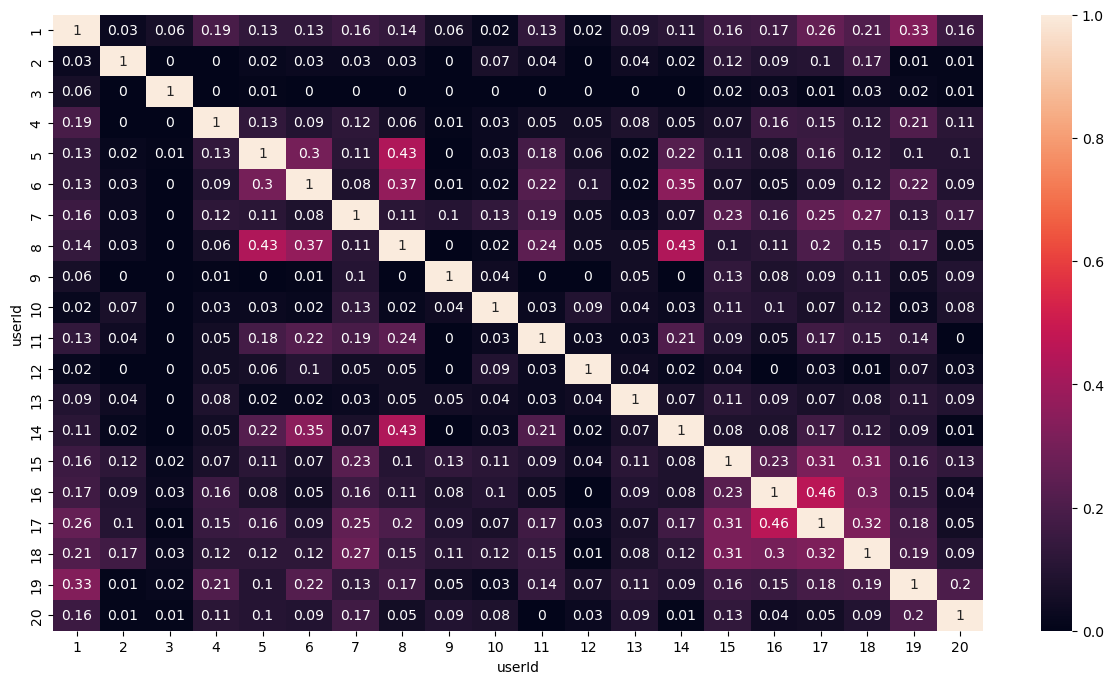

In [171]:
plt.figure(figsize=(15,8))
sns.heatmap(cosine_similarity_user_to_user, annot=True,\
           xticklabels=cosine_similarity_user_to_user.index,\
           yticklabels=cosine_similarity_user_to_user.index);  

In [172]:
cosine_sim_user_to_user = pd.DataFrame(cosine_similarity(cosine_similarity_user_to_user), index=cosine_similarity_user_to_user.index, columns=cosine_similarity_user_to_user.index)

In [173]:
cosine_sim_user_to_user

userId        1         2         3         4         5         6         7   \
userId                                                                         
1       1.000000  0.150833  0.120943  0.485037  0.407776  0.407431  0.477916   
2       0.150833  1.000000  0.012984  0.075288  0.112733  0.114611  0.169387   
3       0.120943  0.012984  1.000000  0.026467  0.033203  0.018953  0.029458   
4       0.485037  0.075288  0.026467  1.000000  0.347313  0.299326  0.366472   
5       0.407776  0.112733  0.033203  0.347313  1.000000  0.658698  0.364347   
6       0.407431  0.114611  0.018953  0.299326  0.658698  1.000000  0.317432   
7       0.477916  0.169387  0.029458  0.366472  0.364347  0.317432  1.000000   
8       0.428987  0.131180  0.021573  0.278599  0.777759  0.741427  0.367693   
9       0.204742  0.057593  0.014152  0.103721  0.069418  0.071898  0.273210   
10      0.153612  0.185499  0.011857  0.140058  0.135145  0.115425  0.325804   
11      0.401469  0.145663  0.018972  0.242274  0.496943  0.542329  0.456983   
12      0.114306  0.026292  0.004787  0.146120  0.176761  0.228884  0.151376   
13      0.276675  0.125511  0.015992  0.236811  0.140461  0.142874  0.183090   
14      0.364029  0.111998  0.016330  0.231243  0.582634  0.702774  0.297496   
15      0.485642  0.305279  0.061248  0.311617  0.350335  0.293708  0.572830   
16      0.494957  0.263564  0.074814  0.416862  0.312698  0.256042  0.484574   
17      0.604776  0.276827  0.053300  0.426777  0.446468  0.368047  0.597686   
18      0.556510  0.367395  0.076001  0.385286  0.395947  0.377426  0.623301   
19      0.684221  0.116812  0.064292  0.504722  0.391816  0.504300  0.436620   
20      0.413425  0.077275  0.038170  0.319679  0.277261  0.263898  0.409016   

userId        8         9         10        11        12        13        14  \
userId                                                                         
1       0.428987  0.204742  0.153612  0.401469  0.114306  0.276675  0.364029   
2       0.131180  0.057593  0.185499  0.145663  0.026292  0.125511  0.111998   
3       0.021573  0.014152  0.011857  0.018972  0.004787  0.015992  0.016330   
4       0.278599  0.103721  0.140058  0.242274  0.146120  0.236811  0.231243   
5       0.777759  0.069418  0.135145  0.496943  0.176761  0.140461  0.582634   
6       0.741427  0.071898  0.115425  0.542329  0.228884  0.142874  0.702774   
7       0.367693  0.273210  0.325804  0.456983  0.151376  0.183090  0.297496   
8       1.000000  0.070880  0.125014  0.576749  0.163283  0.181639  0.780875   
9       0.070880  1.000000  0.136388  0.072777  0.026980  0.149573  0.057755   
10      0.125014  0.136388  1.000000  0.137903  0.196050  0.136031  0.120939   
11      0.576749  0.072777  0.137903  1.000000  0.125649  0.145113  0.530386   
12      0.163283  0.026980  0.196050  0.125649  1.000000  0.109794  0.117062   
13      0.181639  0.149573  0.136031  0.145113  0.109794  1.000000  0.193826   
14      0.780875  0.057755  0.120939  0.530386  0.117062  0.193826  1.000000   
15      0.353180  0.321829  0.305180  0.336693  0.131692  0.299198  0.301328   
16      0.350233  0.244407  0.274329  0.284105  0.069992  0.265767  0.297719   
17      0.494868  0.258669  0.251064  0.455103  0.119092  0.255626  0.437594   
18      0.435764  0.289933  0.316890  0.431384  0.099723  0.265939  0.377970   
19      0.457950  0.185053  0.162545  0.411017  0.188770  0.301563  0.357519   
20      0.218241  0.231873  0.215386  0.144488  0.114859  0.243374  0.143572   

userId        15        16        17        18        19        20  
userId                                                              
1       0.485642  0.494957  0.604776  0.556510  0.684221  0.413425  
2       0.305279  0.263564  0.276827  0.367395  0.116812  0.077275  
3       0.061248  0.074814  0.053300  0.076001  0.064292  0.038170  
4       0.311617  0.416862  0.426777  0.385286  0.504722  0.319679  
5       0.350335  0.312698  0.446468  0.395947  0.391816  0.2772

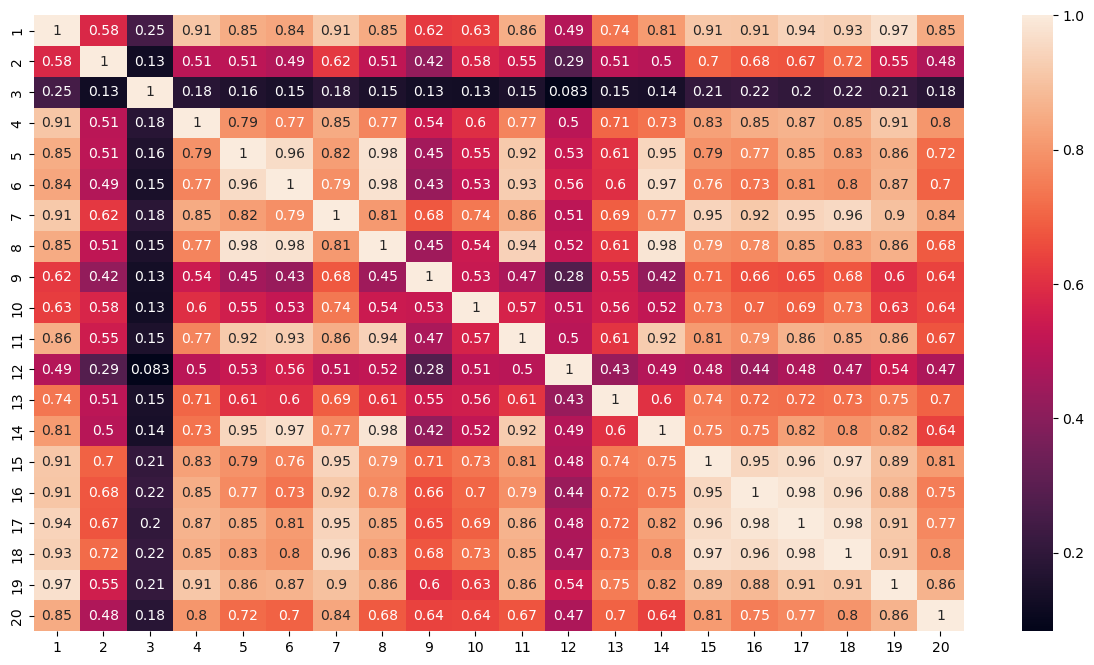

In [174]:
plt.figure(figsize=(15,8))
sns.heatmap(cosine_similarity(cosine_sim_user_to_user), annot=True,\
           xticklabels=cosine_sim_user_to_user.index,\
           yticklabels=cosine_sim_user_to_user.index);  

In [175]:
user_movie_less_20_t = user_movie_less_20.T

In [176]:
user_movie_less_20_t

userId                                     1    2    3    4    5    6    7    \
title                                                                          
'71 (2014)                                 0.0  0.0  0.0  0.0  0.0  0.0  0.0   
'Hellboy': The Seeds of Creation (2004)    0.0  0.0  0.0  0.0  0.0  0.0  0.0   
'Round Midnight (1986)                     0.0  0.0  0.0  0.0  0.0  0.0  0.0   
'Salem's Lot (2004)                        0.0  0.0  0.0  0.0  0.0  0.0  0.0   
'Til There Was You (1997)                  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...                                        ...  ...  ...  ...  ...  ...  ...   
eXistenZ (1999)                            0.0  0.0  0.0  0.0  0.0  0.0  0.0   
xXx (2002)                                 0.0  0.0  0.0  0.0  0.0  0.0  0.0   
xXx: State of the Union (2005)             0.0  0.0  0.0  0.0  0.0  0.0  0.0   
¡Three Amigos! (1986)                      4.0  0.0  0.0  0.0  0.0  0.0  0.0   
À nous la liberté (Freedom for Us) (1931)  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

userId                                     8    9    10   ...  601  602  603  \
title                                                     ...                  
'71 (2014)                                 0.0  0.0  0.0  ...  0.0  0.0  0.0   
'Hellboy': The Seeds of Creation (2004)    0.0  0.0  0.0  ...  0.0  0.0  0.0   
'Round Midnight (1986)                     0.0  0.0  0.0  ...  0.0  0.0  0.0   
'Salem's Lot (2004)                        0.0  0.0  0.0  ...  0.0  0.0  0.0   
'Til There Was You (1997)                  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...                                        ...  ...  ...  ...  ...  ...  ...   
eXistenZ (1999)                            0.0  0.0  0.0  ...  0.0  0.0  5.0   
xXx (2002)                                 0.0  1.0  0.0  ...  0.0  0.0  0.0   
xXx: State of the Union (2005)             0.0  0.0  0.0  ...  0.0  0.0  0.0   
¡Three Amigos! (1986)                      0.0  0.0  0.0  ...  0.0  0.0  0.0   
À nous la liberté (Freedom for Us) (1931)  0.0  0.0  0.0  ...  0.0  0.0  0.0   

userId                                     604  605  606  607  608  609  610  
title                                                                         
'71 (2014)                                 0.0  0.0  0.0  0.0  0.0  0.0  4.0  
'Hellboy': The Seeds of Creation (2004)    0.0  0.0  0.0  0.0  0.0  0.0  0.0  
'Round Midnight (1986)                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
'Salem's Lot (2004)                        0.0  0.0  0.0  0.0  0.0  0.0  0.0  
'Til There Was You (1997)                  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...                                        ...  ...  ...  ...  ...  ...  ...  
eXistenZ (1999)                            0.0  0.0  0.0  0.0  4.5  0.0  0.0  
xXx (2002)                                 0.0  0.0  0.0  0.0  3.5  0.0  2.0  
xXx: State of the Union (2005)             0.0  0.0  0.0  0.0  0.0  0.0  1.5  
¡Three Amigos! (1986)                      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
À nous la liberté (Freedom for Us) (1931)  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[9719 rows x 610 columns]

In [177]:
active_user = np.random.choice(user_movie_less_20.iloc[:20].index)
print(active_user)
unseen_movies = list(user_movie_less_20_t.index[user_movie_less_20_t[active_user] == 0])
unseen_movies

11


["'71 (2014)",
 "'Hellboy': The Seeds of Creation (2004)",
 "'Round Midnight (1986)",
 "'Salem's Lot (2004)",
 "'Til There Was You (1997)",
 "'Tis the Season for Love (2015)",
 "'burbs, The (1989)",
 "'night Mother (1986)",
 '(500) Days of Summer (2009)',
 '*batteries not included (1987)',
 '...All the Marbles (1981)',
 '...And Justice for All (1979)',
 '00 Schneider - Jagd auf Nihil Baxter (1994)',
 '1-900 (06) (1994)',
 '10 (1979)',
 '10 Cent Pistol (2015)',
 '10 Cloverfield Lane (2016)',
 '10 Items or Less (2006)',
 '10 Things I Hate About You (1999)',
 '10 Years (2011)',
 '10,000 BC (2008)',
 '100 Girls (2000)',
 '100 Streets (2016)',
 '101 Dalmatians (1996)',
 '101 Dalmatians (One Hundred and One Dalmatians) (1961)',
 "101 Dalmatians II: Patch's London Adventure (2003)",
 '101 Reykjavik (101 Reykjavík) (2000)',
 '102 Dalmatians (2000)',
 '10th & Wolf (2006)',
 '10th Kingdom, The (2000)',
 '10th Victim, The (La decima vittima) (1965)',
 '11\'09"01 - September 11 (2002)',
 '11:14 (2

In [178]:
neighbours = list(cosine_sim_user_to_user[active_user].sort_values(ascending=False).index[1:4])
neighbours

[8, 6, 14]

In [179]:
user_movie_less_20_t.columns[user_movie_less_20_t.loc['eXistenZ (1999)']>0]

Int64Index([ 95, 101, 125, 182, 198, 267, 312, 352, 387, 391, 414, 425, 452,
            457, 474, 477, 520, 560, 580, 599, 603, 608],
           dtype='int64', name='userId')

In [180]:
# create the recommendation (predicted/rated movie)
predicted_ratings_movies = []

for movie in unseen_movies:
    
    # we check the users who watched the movie
    people_who_have_seen_the_movie = list(user_movie_less_20_t.columns[user_movie_less_20_t.loc[movie] > 0])
    
    num = 0
    den = 0
    for user in neighbours:
        # if this person has seen the movie
        if user in people_who_have_seen_the_movie:
        #  we want extract the ratings and similarities
            rating = user_movie_less_20_t.loc[movie, user]
            similarity = cosine_sim_user_to_user.loc[active_user, user]
            
        # predict the rating based on the (weighted) average ratings of the neighbours
        # sum(ratings)/no.users OR 
        # sum(ratings*similarity)/sum(similarities)
            num = num + rating*similarity
            den = den + similarity
    if den != 0:
        predicted_ratings = num/den
    else:
        predicted_ratings = 0
    predicted_ratings_movies.append([predicted_ratings,movie])
            

In [181]:
df_pred = pd.DataFrame(predicted_ratings_movies,columns = ['rating','movie'])
df_pred.sort_values(by=['rating'],ascending=False)['movie']

7954                              Stargate (1994)
9364                          White Squall (1996)
1928                                 Congo (1995)
6230                      Oliver & Company (1988)
5065                        Lion King, The (1994)
                          ...                    
3270                           Funny Bones (1995)
3271                            Funny Face (1957)
3272                            Funny Farm (1988)
3273                           Funny Games (1997)
9654    À nous la liberté (Freedom for Us) (1931)
Name: movie, Length: 9655, dtype: object

In [182]:
new_user = np.zeros_like(user_movie_less_20.columns)
new_user

array([0, 0, 0, ..., 0, 0, 0], dtype=object)

In [183]:
user_movie_less_20.iloc[:, 5:15]

title   'Tis the Season for Love (2015)  'burbs, The (1989)  \
userId                                                        
1                                   0.0                 0.0   
2                                   0.0                 0.0   
3                                   0.0                 0.0   
4                                   0.0                 0.0   
5                                   0.0                 0.0   
...                                 ...                 ...   
606                                 0.0                 0.0   
607                                 0.0                 0.0   
608                                 0.0                 0.0   
609                                 0.0                 0.0   
610                                 0.0                 0.0   

title   'night Mother (1986)  (500) Days of Summer (2009)  \
userId                                                      
1                        0.0                          0.0   
2                        0.0                          0.0   
3                        0.0                          0.0   
4                        0.0                          0.0   
5                        0.0                          0.0   
...                      ...                          ...   
606                      0.0                          0.0   
607                      0.0                          0.0   
608                      0.0                          0.0   
609                      0.0                          0.0   
610                      0.0                          3.5   

title   *batteries not included (1987)  ...All the Marbles (1981)  \
userId                                                              
1                                  0.0                        0.0   
2                                  0.0                        0.0   
3                                  0.0                        0.0   
4                                  0.0                        0.0   
5                                  0.0                        0.0   
...                                ...                        ...   
606                                0.0                        0.0   
607                                0.0                        0.0   
608                                0.0                        0.0   
609                                0.0                        0.0   
610                                0.0                        0.0   

title   ...And Justice for All (1979)  \
userId                                  
1                                 0.0   
2                                 0.0   
3                                 0.0   
4                                 0.0   
5                                 0.0   
...                               ...   
606                               0.0   
607                               0.0   
608                               0.0   
609                               0.0   
610                               0.0   

title   00 Schneider - Jagd auf Nihil Baxter (1994)  1-900 (06) (1994)  \
userId                                                                   
1                                               0.0                0.0   
2                                               0.0                0.0   
3                                               0.0                0.0   
4                                               0.0                0.0   
5                                               0.0                0.0   
...                                             ...                ...   
606                                             0.0                0.0   
607                                             0.0                0.0   
608                                             0.0                0.0   
609                                             0.0                0.0   
610                                             0.0               

In [184]:
new_user_ratings = {'(500) Days of Summer (2009)': 5,
 '10 (1979)': 3,
 '\'Tis the Season for Love (2015)': 5,
 '*batteries not included (1987)': 5,
  '1-900 (06) (1994)': 5}

In [185]:
for index, item in enumerate(user_movie_less_20.iloc[:20].columns):
    #print(index,item)
    if new_user_ratings.get(item): # <-- Return the value for key if key is in the dictionary
        print(index, item)
        new_user[index] = new_user_ratings[item]

5 'Tis the Season for Love (2015)
8 (500) Days of Summer (2009)
9 *batteries not included (1987)
13 1-900 (06) (1994)
14 10 (1979)


In [186]:
pd.DataFrame([new_user],index = ['new_user'],columns= user_movie_less_20.columns)

title     '71 (2014)  'Hellboy': The Seeds of Creation (2004)  \
new_user           0                                        0   

title     'Round Midnight (1986)  'Salem's Lot (2004)  \
new_user                       0                    0   

title     'Til There Was You (1997)  'Tis the Season for Love (2015)  \
new_user                          0                                5   

title     'burbs, The (1989)  'night Mother (1986)  \
new_user                   0                     0   

title     (500) Days of Summer (2009)  *batteries not included (1987)  ...  \
new_user                            5                               5  ...   

title     Zulu (2013)  [REC] (2007)  [REC]² (2009)  [REC]³ 3 Génesis (2012)  \
new_user            0             0              0                        0   

title     anohana: The Flower We Saw That Day - The Movie (2013)  \
new_user                                                  0        

title     eXistenZ (1999)  xXx (2002)  xXx: State of the Union (2005)  \
new_user                0           0                               0   

title     ¡Three Amigos! (1986)  À nous la liberté (Freedom for Us) (1931)  
new_user                      0                                          0  

[1 rows x 9719 columns]

In [187]:
!pip install fuzzywuzzy
!pip install python-Levenshtein

In [188]:
# for users who make a typo:
from fuzzywuzzy import process
process.extractOne(query= 'Ineion',choices=user_movie_less_20.columns)[0] # <-- it compares the user-provided title with the movie titles and returns the exact title

'Dominion: Prequel to the Exorcist (2005)'

In [189]:
type(new_user)

numpy.ndarray

In [190]:
new_user_df = pd.DataFrame([new_user],index = ['new_user'],columns= user_movie_less_20.columns)
pd.concat([new_user_df, user_movie_less_20])


title     '71 (2014)  'Hellboy': The Seeds of Creation (2004)  \
new_user         0.0                                      0.0   
1                0.0                                      0.0   
2                0.0                                      0.0   
3                0.0                                      0.0   
4                0.0                                      0.0   
...              ...                                      ...   
606              0.0                                      0.0   
607              0.0                                      0.0   
608              0.0                                      0.0   
609              0.0                                      0.0   
610              4.0                                      0.0   

title     'Round Midnight (1986)  'Salem's Lot (2004)  \
new_user                     0.0                  0.0   
1                            0.0                  0.0   
2                            0.0                  0.0   
3                            0.0                  0.0   
4                            0.0                  0.0   
...                          ...                  ...   
606                          0.0                  0.0   
607                          0.0                  0.0   
608                          0.0                  0.0   
609                          0.0                  0.0   
610                          0.0                  0.0   

title     'Til There Was You (1997)  'Tis the Season for Love (2015)  \
new_user                        0.0                              5.0   
1                               0.0                              0.0   
2                               0.0                              0.0   
3                               0.0                              0.0   
4                               0.0                              0.0   
...                             ...                              ...   
606                             0.0                              0.0   
607                             0.0                              0.0   
608                             0.0                              0.0   
609                             0.0                              0.0   
610                             0.0                              0.0   

title     'burbs, The (1989)  'night Mother (1986)  \
new_user                 0.0                   0.0   
1                        0.0                   0.0   
2                        0.0                   0.0   
3                        0.0                   0.0   
4                        0.0                   0.0   
...                      ...                   ...   
606                      0.0                   0.0   
607                      0.0                   0.0   
608                      0.0                   0.0   
609                      0.0                   0.0   
610                      0.0                   0.0   

title     (500) Days of Summer (2009)  *batteries not included (1987)  ...  \
new_user                          5.0                             5.0  ...   
1                                 0.0                             0.0  ...   
2                                 0.0                             0.0  ...   
3                                 0.0                             0.0  ...   
4                                 0.0                             0.0  ...   
...                               ...                             ...  ...   
606                               0.0                             0.0  ...   
607                               0.0                             0.0  ...   
608                               0.0                             0.0  ...   
609                               0.0                             0.0  ...   
610                               3.5                             0.0  ...   

title     Zulu (2013)  [REC] (2007)  [REC]² (2009)  [REC]³ 3 Génesis (2012)  \
new_

# Cosine similarity recommendation function : She made it 

In [219]:
def recommender_cosine(new_user_ratings):
    new_user = np.zeros_like(user_movie_less_20.columns)
    for index, item in enumerate(user_movie_less_20.columns):
    #print(index,item)
        if new_user_ratings.get(item): # <-- Return the value for key if key is in the dictionary
            #print(index, item)
            new_user[index] = new_user_ratings[item]
            
    new_user_df = pd.DataFrame([new_user],index = ['new_user'],columns= user_movie_less_20.columns)
    updated_df = pd.concat([new_user_df, user_movie_less_20]).iloc[:50, :50]
    updated_df_t = updated_df.T
    updated_cosine_sim_table = pd.DataFrame(cosine_similarity(updated_df), index=updated_df.index, columns=updated_df.index)        
    
    active_user = 'new_user'
    unseen_movies = list(updated_df_t.index[updated_df_t[active_user] == 0])
    neighbours = list(updated_cosine_sim_table[active_user].sort_values(ascending=False).index[1:4])
    
    predicted_ratings_movies = []
    for movie in unseen_movies:
    
        # we check the users who watched the movie
        people_who_have_seen_the_movie = list(updated_df_t.columns[updated_df_t.loc[movie] > 0])
    
        num = 0
        den = 0
        for user in neighbours:
            # if this person has seen the movie
            if user in people_who_have_seen_the_movie:
            #  we want extract the ratings and similarities
                rating = updated_df_t.loc[movie, user]
                similarity = updated_cosine_sim_table.loc[active_user, user]
            
            # predict the rating based on the (weighted) average ratings of the neighbours
            # sum(ratings)/no.users OR 
            # sum(ratings*similarity)/sum(similarities)
                num = num + rating*similarity
                den = den + similarity
        if den != 0:
            predicted_ratings = num/den
        else:
            predicted_ratings = 0
        predicted_ratings_movies.append([predicted_ratings,movie])
        
        
    df_pred = pd.DataFrame(predicted_ratings_movies,columns = ['rating','movie'])
    df_pred = df_pred.sort_values(by=['rating'],ascending=False)['movie']
    print(df_pred.iloc[:5])#'Maybe you are interested in watching those movies:\n', 

In [233]:
recommender_cosine({'(500) Days of Summer (2009)': 0,
 '10 (1979)': 3,
 '\'Tis the Season for Love (2015)': 3,
 '*batteries not included (1987)': 5,
  '1-900 (06) (1994)': 2})

35                        12 Years a Slave (2013)
11                          10 Cent Pistol (2015)
26    10th Victim, The (La decima vittima) (1965)
27                 11'09"01 - September 11 (2002)
28                                   11:14 (2003)
Name: movie, dtype: object


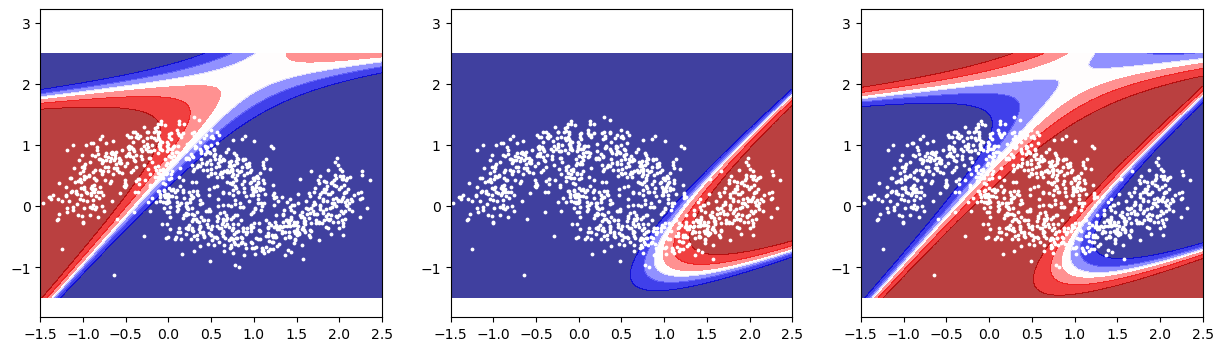

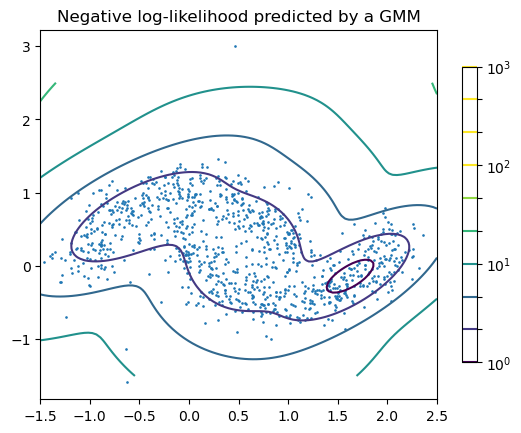

In [193]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.mixture import GaussianMixture


X, _ = make_moons(1000, noise=0.2)
outliers = np.random.normal(0.0, 1.0, (10, 2))

x = np.concatenate([X, outliers])


NCOMP = 3

gmm = GaussianMixture(n_components=NCOMP)
gmm.fit(x)

N = 100
coord = np.linspace(-1.5, 2.5, N)
xx, yy = np.meshgrid(coord, coord)
zz = np.array([xx.ravel(), yy.ravel()]).T

p = gmm.predict_proba(zz)


plt.figure(figsize=(15, 4))
for icomp in range(NCOMP):
    plt.subplot(1, NCOMP, icomp+1)
    comp = p[:, icomp].reshape(xx.shape)
    plt.contourf(xx, yy, comp, alpha=0.75, cmap=plt.cm.seismic)
    plt.scatter(x[:, 0], x[:, 1], color='white', s=3)


plt.figure()
from matplotlib.colors import LogNorm

z = -gmm.score_samples(zz)
z = z.reshape(xx.shape)

CS = plt.contour(xx, yy, z, norm=LogNorm(vmin=1.0, vmax=100.0),
                 levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(x[:, 0], x[:, 1], .8)

plt.title('Negative log-likelihood predicted by a GMM')

plt.show()


In [194]:
merged_df_less_20

movieId             title                                       genres  \
0            1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
1            1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
2            1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
3            1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
4            1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
...        ...               ...                                          ...   
67893   168252      Logan (2017)                                Action|Sci-Fi   
67894   168252      Logan (2017)                                Action|Sci-Fi   
67895   168252      Logan (2017)                                Action|Sci-Fi   
67896   168252      Logan (2017)                                Action|Sci-Fi   
67897   168252      Logan (2017)                                Action|Sci-Fi   

      title_cleaned  year  userId  rating   timestamp  
0        Toy Story   1995       1     4.0   964982703  
1        Toy Story   1995       5     4.0   847434962  
2        Toy Story   1995       7     4.5  1106635946  
3        Toy Story   1995      15     2.5  1510577970  
4        Toy Story   1995      17     4.5  1305696483  
...             ...   ...     ...     ...         ...  
67893        Logan   2017     567     4.0  1525283936  
67894        Logan   2017     586     5.0  1529899336  
67895        Logan   2017     596     5.0  1535627159  
67896        Logan   2017     599     3.5  1498529615  
67897        Logan   2017     610     5.0  1493846352  

[67898 rows x 8 columns]

In [195]:
user_movie_less_20

title   '71 (2014)  'Hellboy': The Seeds of Creation (2004)  \
userId                                                        
1              0.0                                      0.0   
2              0.0                                      0.0   
3              0.0                                      0.0   
4              0.0                                      0.0   
5              0.0                                      0.0   
...            ...                                      ...   
606            0.0                                      0.0   
607            0.0                                      0.0   
608            0.0                                      0.0   
609            0.0                                      0.0   
610            4.0                                      0.0   

title   'Round Midnight (1986)  'Salem's Lot (2004)  \
userId                                                
1                          0.0                  0.0   
2                          0.0                  0.0   
3                          0.0                  0.0   
4                          0.0                  0.0   
5                          0.0                  0.0   
...                        ...                  ...   
606                        0.0                  0.0   
607                        0.0                  0.0   
608                        0.0                  0.0   
609                        0.0                  0.0   
610                        0.0                  0.0   

title   'Til There Was You (1997)  'Tis the Season for Love (2015)  \
userId                                                               
1                             0.0                              0.0   
2                             0.0                              0.0   
3                             0.0                              0.0   
4                             0.0                              0.0   
5                             0.0                              0.0   
...                           ...                              ...   
606                           0.0                              0.0   
607                           0.0                              0.0   
608                           0.0                              0.0   
609                           0.0                              0.0   
610                           0.0                              0.0   

title   'burbs, The (1989)  'night Mother (1986)  (500) Days of Summer (2009)  \
userId                                                                          
1                      0.0                   0.0                          0.0   
2                      0.0                   0.0                          0.0   
3                      0.0                   0.0                          0.0   
4                      0.0                   0.0                          0.0   
5                      0.0                   0.0                          0.0   
...                    ...                   ...                          ...   
606                    0.0                   0.0                          0.0   
607                    0.0                   0.0                          0.0   
608                    0.0                   0.0                          0.0   
609                    0.0                   0.0                          0.0   
610                    0.0                   0.0                          3.5   

title   *batteries not included (1987)  ...  Zulu (2013)  [REC] (2007)  \
userId                                  ...                              
1                                  0.0  ...          0.0           0.0   
2                                  0.0  ...          0.0           0.0   
3                                  0.0  ...          0.0           0.0   
4                                  0.0  ...          0.0           0.0   
5                                  0.0  ...          0.

# PCA

In [196]:
from sklearn.decomposition import PCA

In [197]:
raw = user_movie_less_20.copy()

In [117]:
scaler = StandardScaler()
user_movie_less_20 = scaler.fit_transform(user_movie_less_20)
user_movie_less_20

array([[-0.04052204, -0.04052204, -0.05735393, ..., -0.08870074,
         5.84559005, -0.04052204],
       [-0.04052204, -0.04052204, -0.05735393, ..., -0.08870074,
        -0.2019994 , -0.04052204],
       [-0.04052204, -0.04052204, -0.05735393, ..., -0.08870074,
        -0.2019994 , -0.04052204],
       ...,
       [-0.04052204, -0.04052204, -0.05735393, ..., -0.08870074,
        -0.2019994 , -0.04052204],
       [-0.04052204, -0.04052204, -0.05735393, ..., -0.08870074,
        -0.2019994 , -0.04052204],
       [24.67792536, -0.04052204, -0.05735393, ...,  8.02741663,
        -0.2019994 , -0.04052204]])

In [118]:
df = pd.DataFrame(user_movie_less_20, index=raw.index, columns=raw.columns)

In [120]:
df.shape

(610, 9719)

**Calculate covariance matrix**

In [121]:
cov_matrix = np.cov(df, rowvar=False, ddof=0)  # /(N-ddof)

In [122]:
cov_matrix

array([[ 1.        , -0.00164204, -0.0023241 , ...,  0.32528734,
        -0.00818543, -0.00164204],
       [-0.00164204,  1.        ,  0.706526  , ..., -0.00359434,
        -0.00818543, -0.00164204],
       [-0.0023241 ,  0.706526  ,  1.        , ..., -0.00508734,
        -0.01158546, -0.0023241 ],
       ...,
       [ 0.32528734, -0.00359434, -0.00508734, ...,  1.        ,
        -0.0179175 , -0.00359434],
       [-0.00818543, -0.00818543, -0.01158546, ..., -0.0179175 ,
         1.        , -0.00818543],
       [-0.00164204, -0.00164204, -0.0023241 , ..., -0.00359434,
        -0.00818543,  1.        ]])

In [ ]:
cov_matrix = np.corrcoef(df, rowvar=False)

In [103]:
pca = PCA(n_components=2)

In [108]:
pca.fit(user_movie_less_20)

PCA(n_components=2)

In [109]:
print(pca.explained_variance_ratio_.sum()*100)

17.88630890700353


In [110]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

NameError: name 'X_reduced' is not defined

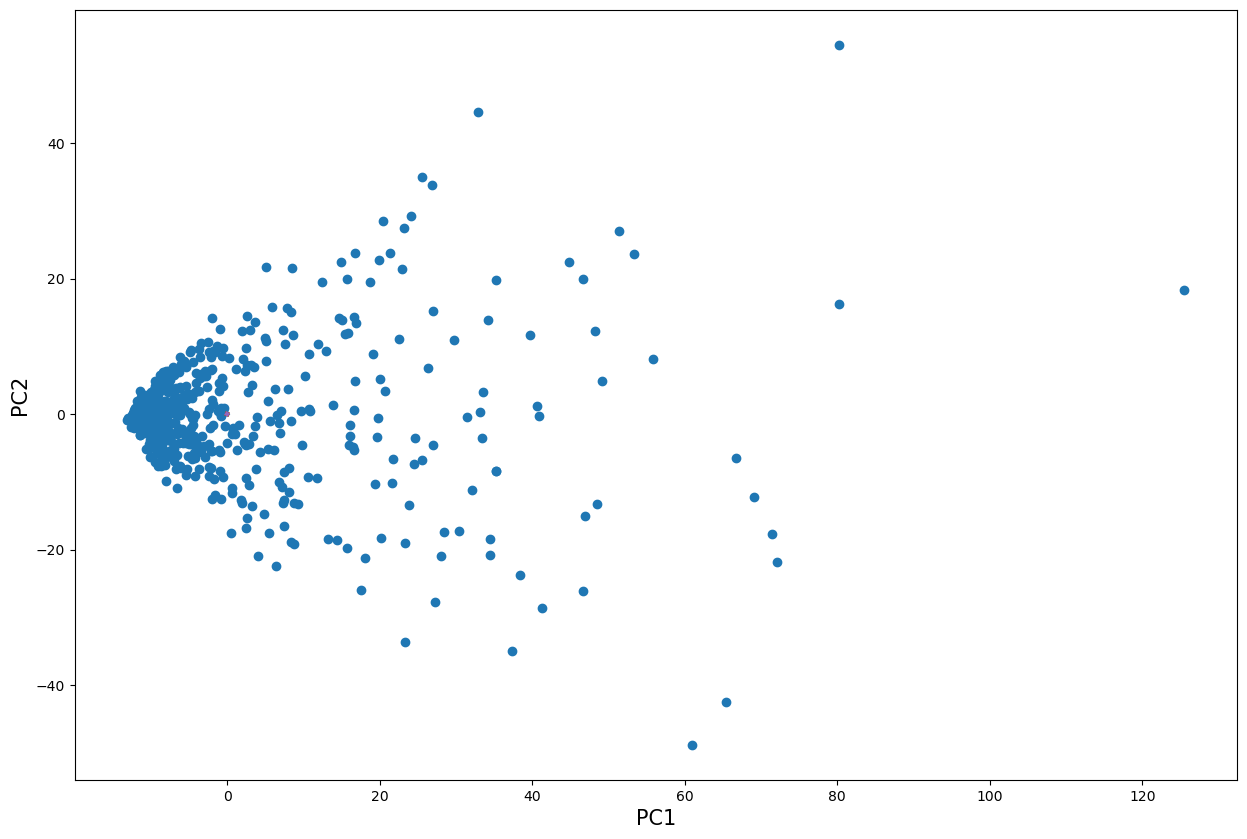

In [115]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(pca.transform(user_movie_less_20)[:,0], pca.transform(user_movie_less_20)[:,1])
ax.plot([0, loadings[0,0]], [0, loadings[0,1]], lw=3, label='1')
ax.plot([0, loadings[1,0]], [0, loadings[1,1]], lw=3, label='2')
ax.plot([0, loadings[2,0]], [0, loadings[2,1]], lw=3, label='3')
ax.plot([0, loadings[3,0]], [0, loadings[3,1]], lw=3, label='4')
ax.plot([0, loadings[4,0]], [0, loadings[4,1]], lw=3, label='5')
ax.set_xlabel('PC1', fontsize=15)
ax.set_ylabel('PC2', fontsize=15)
for i in range(user_movie_less_20.shape[0]):
    plt.text(X_reduced[i,0], X_reduced[i,1], str(user_movie_less_20.index[i]))
ax.legend(fontsize=15)
ax.tick_params('both', labelsize=15)